In [2]:
#def dataLoad():

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpl
%matplotlib inline
plt.style.use(['grayscale','ggplot'])

plt.style.available


['fivethirtyeight', 'bmh', 'grayscale', 'ggplot', 'dark_background']

In [3]:
## string to int with ignore none disit
def toint(s,default=0):
    converted = default
    try :
        converted = int(s)
    except:
        #print('string convert exception "{0}" (default={1})"'.format(s , default))
        pass
    return converted

class music_recsys:
    model = None
    home_dir = '/Users/goodvc/Data/fastcampus/week5/resource/music-ds/'
    w2v_env = { 'min_count':5, 'size':100, 'window':5 }
    nn_func = None
    
    ## initialize
    def __init__(self):
        self.dataLoad()
    
    ## dataset load
    def dataLoad(self):
        ## music streaming log data
        self.streamings = pd.read_csv(self.home_dir+'streaming_ds.csv', 
                                      names = ['MEM_UNO', 'SONG_ID', 'ARTIST_ID', 'GENRE_CODE', 'REG_DATE'])
        self.streamings = self.streamings.convert_objects(convert_numeric=True).dropna()
        self.genre = pd.read_csv(self.home_dir+'genre.csv', 
                                      names = ['GENRE_CODE', 'GENRE_NAME'])
        self.artist = pd.read_csv(self.home_dir+'artist.csv', 
                                      names = ['ARTIST_ID', 'ARTIST_NAME'])

In [4]:
rs = music_recsys()

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/pandas/io/parsers.py:1159: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [6]:
## data statistics  
print( 'streamings count ', rs.streamings.count()[0])
print( 'user count ', len(rs.streamings['SONG_ID'].unique()) )
print( 'music count ', len(rs.streamings['ARTIST_ID'].unique()) )
print( 'date ', rs.streamings['REG_DATE'].min(), '~', rs.streamings['REG_DATE'].max() )

print( '**** streamings sample ****\n', rs.streamings.head())

streamings count  903346
user count  79276
music count  15566
date  20150901080000 ~ 20150901085959
**** streamings sample ****
      MEM_UNO   SONG_ID  ARTIST_ID GENRE_CODE        REG_DATE
1  305823986  15961710   14948305      L0602  20150901084922
2  303507290  15962335   14945136      L0902  20150901081553
3  303519720  15962336   14945123      L0902  20150901080234
4  301688860  15962336   14945123      L0902  20150901080406
5  302998750  15962336   14945123      L0902  20150901083020


In [11]:
## user 음원 플레이수 분포
user_counts = rs.streamings.groupby(['MEM_UNO'])['SONG_ID'].count()
print('user당 시청 음원수 mean', user_counts.mean())
print('user당 시청 음원수 median', user_counts.median())

print('user당 시청 음원수 skew', user_counts.skew())

user당 시청 음원수 mean 6.99460313282
user당 시청 음원수 median 6.0
user당 시청 음원수 skew 0.992547054812


In [17]:
# 20회 이상 플레이한 사용자는 20회로 만듦
user_counts = user_counts.apply(lambda x: x if x<20 else 20)

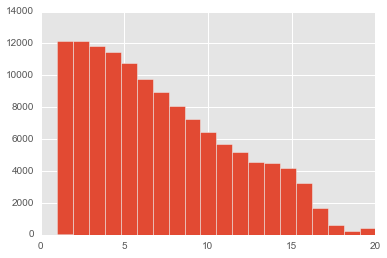

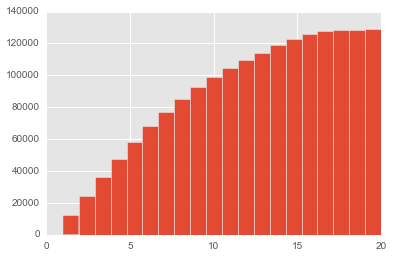

In [59]:
user_counts.hist(bins=20)
plt.show()
user_counts.hist(bins=20, cumulative=True)
plt.show()

In [24]:
## 음원별 시청수 분포
song_counts = rs.streamings.groupby(['SONG_ID'])['MEM_UNO'].count()
song_counts.sort(ascending=False, axis=1)
print('음원별 시청수 mean', song_counts.mean())
print('음원별 시청수 median', song_counts.median())
print('음원별 시청수 skew', song_counts.skew())

음원별 시청수 mean 11.3949492911
음원별 시청수 median 1.0
음원별 시청수 skew 71.902063811


In [63]:
## 1000번 이상 플레이한 수를 1000으로 만듦
song_counts = song_counts.apply(lambda x: x if x<1000 else 1000)

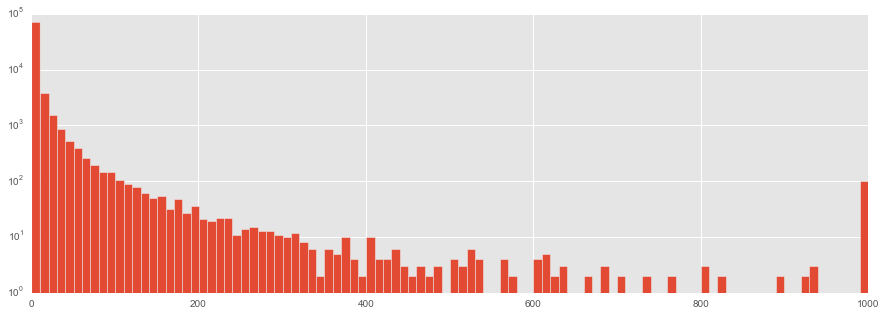

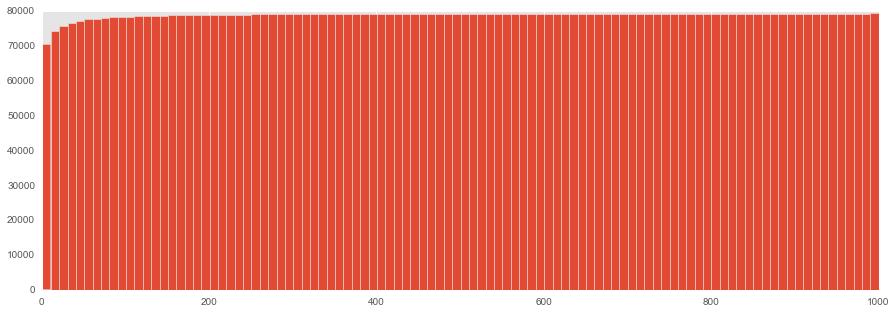

In [66]:
song_counts.hist(bins=100, figsize=(15,5))
plt.yscale('log')
plt.show()
song_counts.hist(bins=100, cumulative=True, figsize=(15,5),)
plt.show()


In [89]:
## 얼마나 몰려 있는가?
song_counts = rs.streamings.groupby(['SONG_ID'])['MEM_UNO'].count()
song_counts.sort(ascending=False, axis=1)
song_counts_ds = song_counts.cumsum().to_frame()

In [124]:
total = song_counts.sum()
count = song_counts.count()
song_counts_ds['cumsum_rate'] = (song_counts_ds['MEM_UNO']/total)*100
song_counts_ds['count_rate'] = np.arange(1,count+1)/count*100

song_counts_ds.reset_index().iloc[range(0,count,int(count/100+1)),[3,2]]

,count_rate,cumsum_rate
0,0.001261,2.560149
793,1.001564,55.494351
1586,2.001867,63.427081
2379,3.002170,68.261773
3172,4.002472,71.712500
3965,5.002775,74.378588
4758,6.003078,76.535347
5551,7.003381,78.313957
6344,8.003683,79.809176
7137,9.003986,81.104582


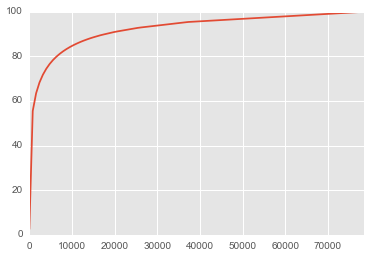

In [135]:
song_counts_ds.reset_index().iloc[range(0,count,int(count/100+1)),[3,2]]['cumsum_rate'].plot()